In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

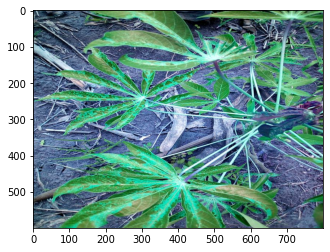

In [2]:
img_example=cv2.imread('../input/iitgai-hackathon-2-2021-2022/train_images/train_images/1000201771.jpg')
plt.imshow(img_example)

In [3]:
img_example.shape

(600, 800, 3)

In [4]:
df=pd.read_csv("../input/iitgai-hackathon-2-2021-2022/train_data.csv")
df.head()

,image_id,label
0,6103,3
1,218377,1
2,336550,3
3,469487,1
4,690163,3


In [5]:
df=df.astype({'image_id': 'str','label':'str'})
df.dtypes

image_id    object
label       object
dtype: object

In [6]:
df['image_id']=df['image_id']+'.jpg'

In [7]:
df.head()

,image_id,label
0,6103.jpg,3
1,218377.jpg,1
2,336550.jpg,3
3,469487.jpg,1
4,690163.jpg,3


In [8]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df,test_size=0.2)

In [9]:
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.preprocessing.image import load_img, img_to_array
train_datagen=IDG(rescale=1/255,rotation_range=30,shear_range=0.1,horizontal_flip=True,
                  zoom_range=0.2,brightness_range=[0.4,1.0],height_shift_range=0.2,width_shift_range=0.2)
test_datagen=IDG(rescale=1/255)
train_df=train_datagen.flow_from_dataframe(train_df,directory="../input/iitgai-hackathon-2-2021-2022/train_images/train_images",
                                           x_col="image_id",y_col="label",target_size=(300,300), shuffle=True)
valid_df=test_datagen.flow_from_dataframe(valid_df,directory="../input/iitgai-hackathon-2-2021-2022/train_images/train_images",
                                           x_col="image_id",y_col="label",target_size=(300,300), shuffle=True)


Found 13132 validated image filenames belonging to 5 classes.
Found 3284 validated image filenames belonging to 5 classes.


In [10]:
test_df=test_datagen.flow_from_directory("../input/iitgai-hackathon-2-2021-2022/test_images",shuffle=False,
                                         target_size=(300,300))

Found 4981 images belonging to 1 classes.


In [11]:
base_model=tf.keras.applications.EfficientNetB3(include_top=False,weights='imagenet',input_shape=(300,300,3))
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))    
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
for layers in base_model.layers:
    layers.trainable=False
model.summary()

2021-12-18 12:03:13.007456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 12:03:13.110564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 12:03:13.111259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 12:03:13.112957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________

In [12]:
save_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoint',save_weights_only=False,monitor='val_loss',
                                             save_best_only=True)
checkpoint_path="./checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [13]:
early_stop= EarlyStopping(
                                monitor = "val_accuracy",
                                min_delta=0.001,
                                patience=5,
                                verbose=1,
                                mode="max")

In [14]:
reduce_lr = ReduceLROnPlateau(
                                monitor="val_accuracy",
                                factor=0.1,
                                patience=2,
                                verbose=1,
                                min_delta=0.0001)

In [15]:
model.fit(train_df,validation_data=valid_df,epochs=20,steps_per_epoch=train_df.n//train_df.batch_size,validation_steps=valid_df.n//valid_df.batch_size,callbacks=[early_stop,reduce_lr])

2021-12-18 12:03:20.987283: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-18 12:03:35.188067: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


410/410 [==============================] - 639s 2s/step - loss: 1.0862 - accuracy: 0.6711 - val_loss: 2.4653 - val_accuracy: 0.1305
Epoch 2/20
410/410 [==============================] - 536s 1s/step - loss: 0.7752 - accuracy: 0.7505 - val_loss: 18.7380 - val_accuracy: 0.2944
Epoch 3/20
410/410 [==============================] - 537s 1s/step - loss: 0.5716 - accuracy: 0.8021 - val_loss: 10.4205 - val_accuracy: 0.1173
Epoch 4/20
410/410 [==============================] - 539s 1s/step - loss: 0.5074 - accuracy: 0.8284 - val_loss: 1.7483 - val_accuracy: 0.1308

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
410/410 [==============================] - 541s 1s/step - loss: 0.4469 - accuracy: 0.8473 - val_loss: 1.3704 - val_accuracy: 0.5297
Epoch 6/20
410/410 [==============================] - 544s 1s/step - loss: 0.4161 - accuracy: 0.8611 - val_loss: 0.8426 - val_accuracy: 0.6893
Epoch 7/20
410/410 [==============================] - 547s 1s/step - 

In [16]:
pred=model.predict(test_df,verbose=1)
np.save('resnet', pred)

156/156 [==============================] - 80s 504ms/step


In [17]:
predictions = np.argmax(pred, axis=1)
filenames   = test_df.filenames

In [18]:
result=pd.DataFrame({"image_id":filenames,"label":predictions})
result['image_id']=result['image_id'].map(lambda x: x.lstrip('test_images/').rstrip('.jpg'))
result['label']=result['label'].astype(int)
result.to_csv("results.csv",index=False)
result.head()

,image_id,label
0,3286502189,3
1,3286807982,3
2,3287098987,3
3,3287200393,3
4,3287300042,3


In [19]:
result.label.unique()

array([3, 4, 2, 1, 0])